In [1]:
from ga.ga_hlm import *
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [6]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = 10000-1

In [4]:
dams = [9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.5 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [3.0 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(4.5)
        H_max.append(5)
        diam.append(1.0)
        S_max.append(200000)
        L_spill.append(2.0)
        L_crest.append(5.0)
    elif dam in order_4:
        H_spill.append(4.5)
        H_max.append(5.0)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(4.0)
        L_crest.append(10.0)
        

In [7]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te],forcing, rtol=1e-6,)

Model 254 is being used!
9999

In [8]:
SSN2 = Watershed(Model=256)
SSN2.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN2.dam_ids = dams
dam_params256 = SSN2.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN2.set_dam_state(states=[0.5 for _ in range(n_dams)])
SSN2.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passive05, st_passive05 = SSN2.Run_256( [0, te], forcing, dam_params256)

Model 256 (254 with_dams) is being used!
9999

In [10]:
SSN3 = Watershed(Model=256)
SSN3.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN3.dam_ids = dams
dam_params256 = SSN3.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN3.set_dam_state(states=[1 for _ in range(n_dams)])
SSN3.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passive10, st_passive10 = SSN3.Run_256( [0, te], forcing, dam_params256)

Model 256 (254 with_dams) is being used!
9999

In [21]:

def RunSimulation(args):
    object, state , t0, forcing, dam_parameters, t_next = args
    object.set_dam_state(states=state)
    dc_test, st_test = object.Run_256( [t0, t0+t_next], forcing, dam_parameters)
    flow_max = dc_test.max(axis=0)
    # volume_max = st_test.max(axis=0)
    # flow_last = dc_test.iloc[-1]
    volume_last = st_test.iloc[-1]
    return [dc_test, st_test]#[flow_max, volume_last]#, 

In [19]:
SSN5 = Watershed(Model=256)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)

Model 256 (254 with_dams) is being used!


In [34]:
population = InitialPopulation2(10, n_dams)
for state in population[1:2]:
    sim= RunSimulation([SSN5, state , 0, forcing, dam_params256,5000])

5000

In [25]:
#[9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
population[1:2]

array([[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]])

In [35]:
population[1:2]


array([[0.75, 0.  , 0.5 , 0.25, 1.  , 1.  , 0.  , 0.5 , 0.25, 0.5 , 0.75,
        1.  , 0.5 , 0.75, 0.25, 0.75, 0.5 , 0.25, 0.5 ]])

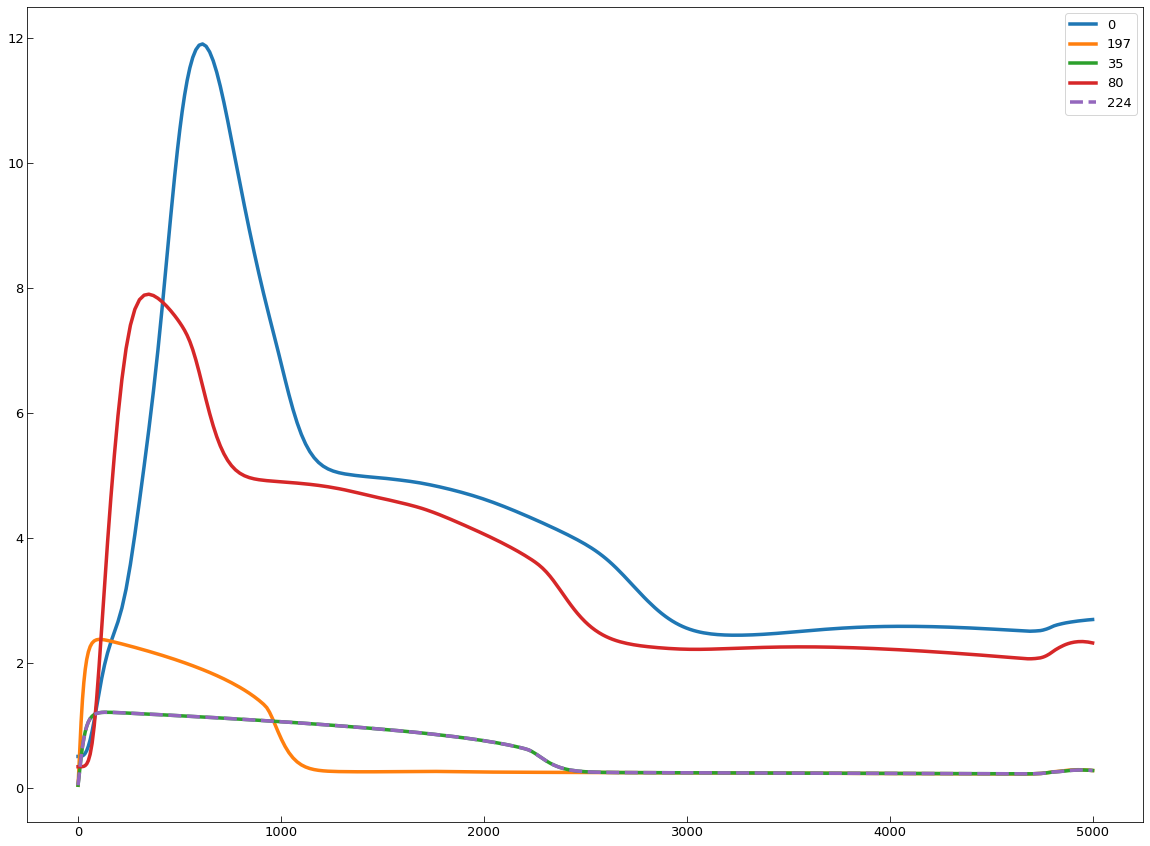

In [36]:
fig, ax = plt.subplots(figsize=(20, 15))
# ax.set_yscale('log')
sim[0].plot(y='0', ax=ax)
sim[0].plot(y='197', ax=ax)
sim[0].plot(y='35', ax=ax)
sim[0].plot(y='80', ax=ax)
sim[0].plot(y='224', ax=ax, linestyle='dashed')

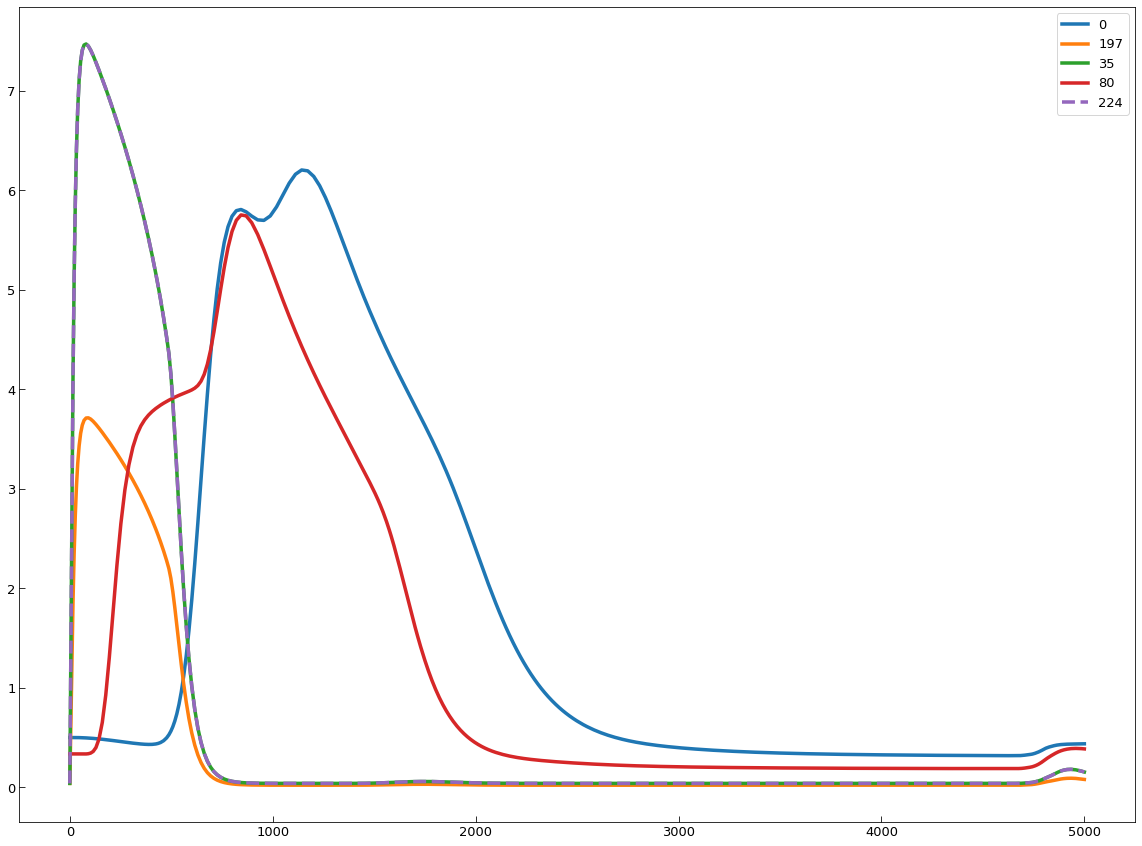

In [33]:
fig, ax = plt.subplots(figsize=(20, 15))
# ax.set_yscale('log')
sim[0].plot(y='0', ax=ax)
sim[0].plot(y='197', ax=ax)
sim[0].plot(y='35', ax=ax)
sim[0].plot(y='80', ax=ax)
sim[0].plot(y='224', ax=ax, linestyle='dashed')


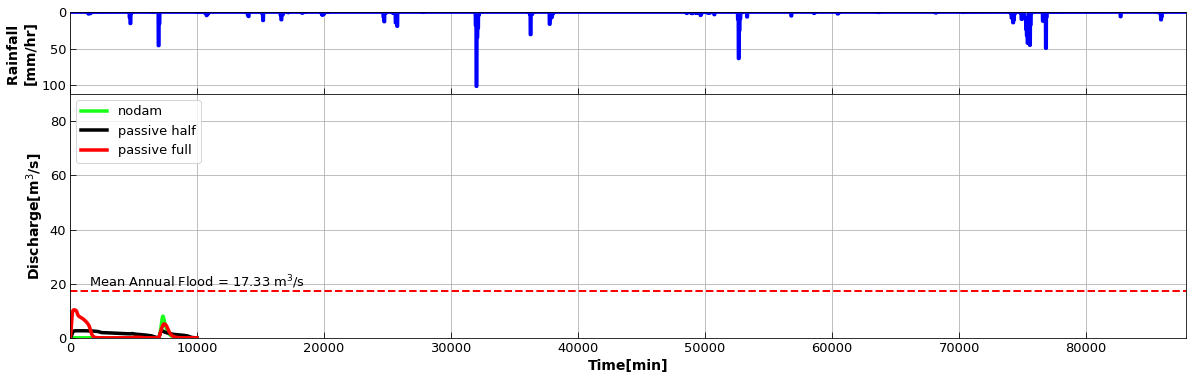

In [17]:
s_name = '_h45_5_O75_1_10_19dams' 
pltKwargs = [{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passive half', 'color':'k'},{'label':'passive full', 'color':'red'}]
plot_sim(81, forcing, [dc_nodam, dc_passive05, dc_passive10], pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25)

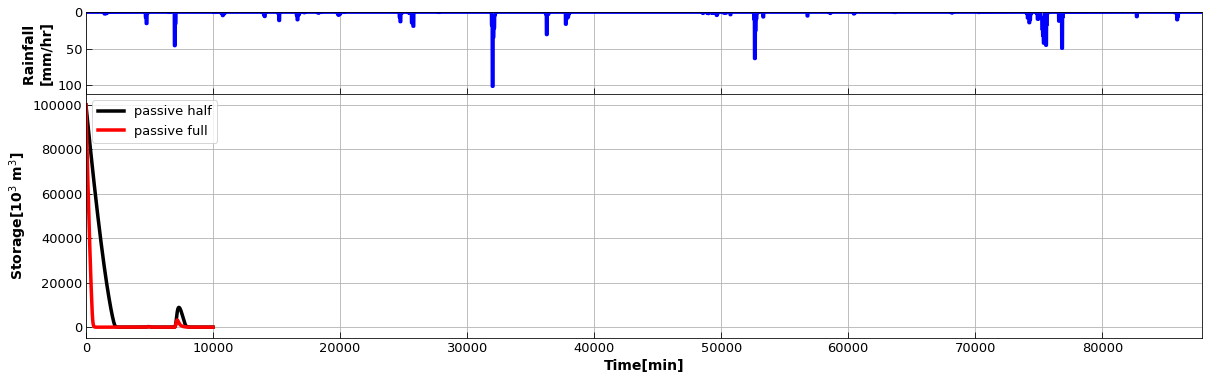

In [18]:
plot_sim(9, forcing, [st_passive05, st_passive10], pltKwargs[1:], d_type='storage')

In [47]:

from imp import reload 
import hlm_basic
reload(hlm_basic.tools)
from hlm_basic.tools import plot_sim